In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
%pip install torch-geometric
%pip install lime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
/kaggle/input/google-sheets-api/crop-yield-prediction-452008-05e1862c508c.json
/kaggle/input/gyga-uganda-supervised/GygaModelRunsUganda - Rainfed maize model runs.csv
/kaggle/input/gyga-uganda-supervised/GygaUganda - Station.csv


In [22]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os 
import time  
from google.oauth2 import service_account
from googleapiclient.discovery import build


In [23]:
# Read the dataset
df = pd.read_csv("/kaggle/input/gyga-uganda-supervised/GygaUganda - Station.csv")

Epoch 0, Loss: 0.5179235339164734
Epoch 10, Loss: 0.3896128535270691
Epoch 20, Loss: 0.30328673124313354
Epoch 30, Loss: 0.2175331860780716
Epoch 40, Loss: 0.13022470474243164
Epoch 50, Loss: 0.08826904743909836
Epoch 60, Loss: 0.060739971697330475
Epoch 70, Loss: 0.04881805554032326
Epoch 80, Loss: 0.03800438344478607
Epoch 90, Loss: 0.028854873031377792
Normal Data Accuracy: 95.00%
Anomaly Detection Accuracy: 5.00%
Precision: 100.00%
Training Accuracy: 95.86%
Results appended to Google Sheet (Sheet2).


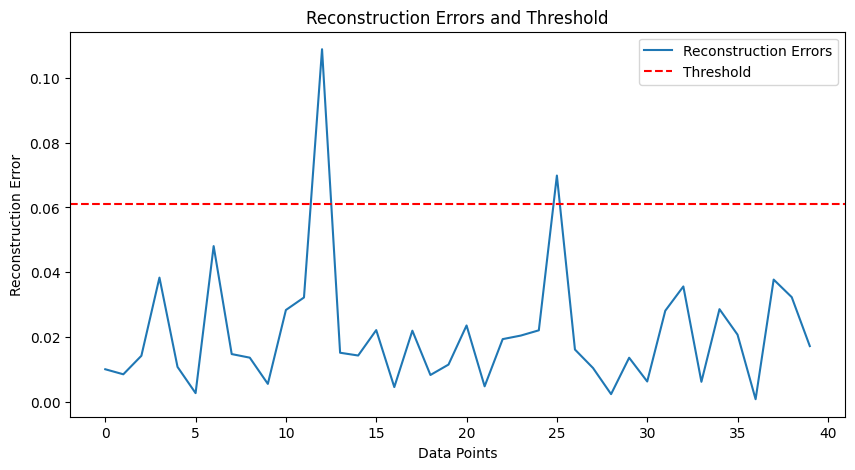

tensor([0.0101, 0.0085, 0.0143, 0.0384, 0.0108, 0.0027, 0.0481, 0.0148, 0.0137,
        0.0056, 0.0284, 0.0322, 0.1088, 0.0152, 0.0143, 0.0222, 0.0046, 0.0220,
        0.0083, 0.0115, 0.0236, 0.0048, 0.0194, 0.0205, 0.0221, 0.0698, 0.0162,
        0.0105, 0.0024, 0.0137, 0.0063, 0.0281, 0.0356, 0.0062, 0.0286, 0.0208,
        0.0009, 0.0377, 0.0323, 0.0172])


In [24]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from google.oauth2 import service_account
from googleapiclient.discovery import build

# Read the dataset
df = pd.read_csv("/kaggle/input/gyga-uganda-supervised/GygaUganda - Station.csv")

target_variable = "YA"
numerical_features = ["YW", "YW-YA", "YP", "WPP", "WPA", "CROPPING_INTENSITY"]
categorical_features = ["CROP", "CLIMATEZONE", "COUNTRY"]

X = df.drop(target_variable, axis=1)
y = df[target_variable]

# Preprocessing
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])

# Apply preprocessing to the entire dataset (unsupervised)
X_transformed = preprocessor.fit_transform(X)
x_tensor = torch.tensor(X_transformed, dtype=torch.float)

# Create KNN edges
def create_knn_edges(df, k=5):
    coords = df[['LONGITUDE', 'LATITUDE']].values
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(coords)
    distances, neighbor_indices = knn.kneighbors(coords)
    edge_index = []
    for i, neighbors in enumerate(neighbor_indices):
        for j in neighbors:
            edge_index.append([i, j])
    return torch.tensor(edge_index, dtype=torch.long).t()

data = Data(x=x_tensor, edge_index=create_knn_edges(df))

class SAGEAutoencoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super(SAGEAutoencoder, self).__init__()
        self.encoder_conv1 = SAGEConv(in_channels, hidden_channels)
        self.encoder_conv2 = SAGEConv(hidden_channels, latent_channels)
        self.decoder_conv1 = SAGEConv(latent_channels, hidden_channels)
        self.decoder_conv2 = SAGEConv(hidden_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.encoder_conv1(x, edge_index))
        return self.encoder_conv2(x, edge_index)

    def decode(self, z, edge_index):
        z = F.relu(self.decoder_conv1(z, edge_index))
        return self.decoder_conv2(z, edge_index)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index)

# Model Initialization
in_channels = data.x.shape[1]
hidden_channels = 64
latent_channels = 32
model = SAGEAutoencoder(in_channels, hidden_channels, latent_channels)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss
loss_values = []

# Training Loop with timing
start_time = time.time()
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    reconstructed_x = model(data.x, data.edge_index)
    loss = loss_fn(reconstructed_x, data.x)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
end_time = time.time()
training_time = end_time - start_time

# Anomaly detection
model.eval()
with torch.no_grad():
    reconstructed_x = model(data.x, data.edge_index)
    reconstruction_errors = F.mse_loss(reconstructed_x, data.x, reduction='none').mean(dim=1)

# Thresholding
threshold = reconstruction_errors.mean() + 2 * reconstruction_errors.std()

# Classify data points
anomalies = reconstruction_errors > threshold
normals = reconstruction_errors <= threshold

# Calculate "accuracy"
num_anomalies = anomalies.sum().item()
num_normals = normals.sum().item()
total_data_points = len(reconstruction_errors)

normal_accuracy = (num_normals / total_data_points) * 100
anomaly_accuracy = (num_anomalies / total_data_points) * 100

# Calculate precision (for anomaly detection, precision is relevant)
if num_anomalies > 0:
    precision = num_anomalies / (num_anomalies + (total_data_points - num_normals - num_anomalies)) * 100
else:
    precision = 0.0

# calculate training accuracy
training_loss = loss_values[-1]
training_accuracy = (1 - training_loss / torch.mean(data.x**2).item()) * 100 #Normalized training accuracy.

print(f"Normal Data Accuracy: {normal_accuracy:.2f}%")
print(f"Anomaly Detection Accuracy: {anomaly_accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Training Accuracy: {training_accuracy:.2f}%")

# Prepare results for Google Sheets and CSV
results = {
    "Model Name": "SGATs Autoencoder (Anomaly Detection)",
    "Training Time (seconds)": training_time,
    "Epoch": epoch,
    "Final Loss": loss.item(),
    "Normal Data Accuracy": normal_accuracy,
    "Anomaly Detection Accuracy": anomaly_accuracy,
    "Threshold": threshold.item(),
    "Precision": precision,
    "Learning Rate": learning_rate,
    "Training Accuracy": training_accuracy
}

# Google Sheets Integration
SERVICE_ACCOUNT_FILE = '/kaggle/input/google-sheets-api/crop-yield-prediction-452008-05e1862c508c.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SPREADSHEET_ID = '143Gaf6z2s2hSIWjMZXw6snPuUPSZ6WViYZKmagmCzho'
creds = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)
sheet = service.spreadsheets()

# Get the next available row in Sheet2
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range="Sheet2!A1:A").execute()
num_rows = len(result.get('values', [])) + 1

values = [
    [
        results["Model Name"],
        results["Training Time (seconds)"],
        results["Epoch"],
        results["Final Loss"],
        f"{results['Normal Data Accuracy']:.2f}%",
        f"{results['Anomaly Detection Accuracy']:.2f}%",
        results["Threshold"],
        f"{results['Precision']:.2f}%",
        results["Learning Rate"],
        f"{results['Training Accuracy']:.2f}%"
    ]
]

body = {'values': values}
sheet.values().append(spreadsheetId=SPREADSHEET_ID, range=f"Sheet2!A{num_rows}", valueInputOption="USER_ENTERED", body=body).execute()

print("Results appended to Google Sheet (Sheet2).")

# Prepare results for CSV
file_path = "anomaly_results.csv"
if os.path.exists(file_path):
    results_df = pd.DataFrame([results])
    results_df.to_csv(file_path, mode='a', header=False, index=False)
else:
    results_df = pd.DataFrame([results])
    results_df.to_csv(file_path, mode='w', header=True, index=False)

# Plot reconstruction errors and threshold
plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors.numpy(), label="Reconstruction Errors")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Errors and Threshold")
plt.legend()
plt.show()

print(reconstruction_errors)

## 1. Feature Importance Using Random Forests
- Using a Random Forest model to determine feature importance before feeding the data into the neural network.

- Longer Bars = More Important Features: Features with longer bars have higher importance scores, meaning they have a greater impact on the model's predictions.

- Shorter Bars = Less Important Features: Features with shorter bars have lower importance scores, indicating they are less influential.

-  Feature importance helps us understand which factors are most relevant in predicting the target. This is valuable for domain experts to gain insights into the underlying relationships in the data.

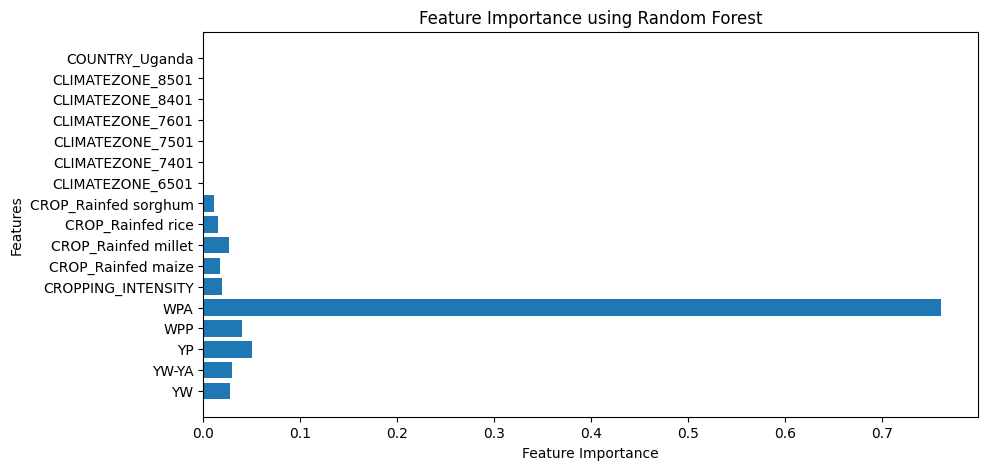

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()


In [26]:
print("X_transformed shape:", X_transformed.shape)  # (40, 17)
print("Number of numerical features:", len(numerical_features))  # 6
print("Feature names used:", numerical_features)



X_transformed shape: (40, 17)
Number of numerical features: 6
Feature names used: ['YW', 'YW-YA', 'YP', 'WPP', 'WPA', 'CROPPING_INTENSITY']


## Partial Dependence Plot
PDPs make the model more explainable by showing the patterns the model has learned for individual features.

`Code Explanation`
- The partial dependence increases as `num_YW` increases, suggesting a positive relationship between `num_YW` and the predicted target.
- Similar to `num_YW`, there's a positive relationship. As `num_YW-YA` increases, the predicted target tends to increase.
- This plot is more complex. There's a steep increase in partial dependence around `num_YP` = 1, suggesting a strong positive impact of `num_YP` on the predicted target in that region.

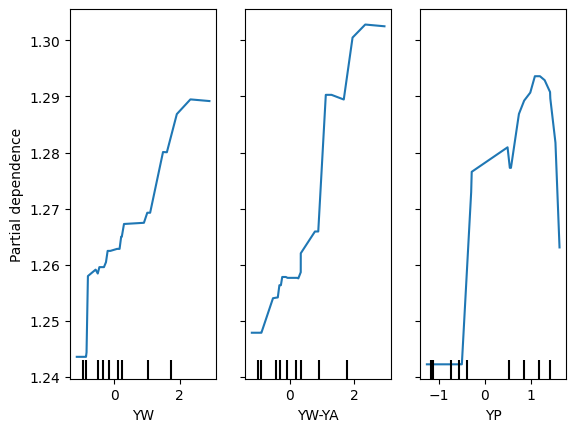

In [30]:
from sklearn.inspection import PartialDependenceDisplay

# Define the features for PDP
features = [0, 1, 2]  # Adjust indices based on your feature order

# Plot PDP using PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=features, feature_names=feature_names)
plt.show()


## Permutation Importance
Permutation Importance measures how much a model's performance (in our case, likely accuracy or R-squared since it's a regression task) decreases when a feature is randomly shuffled. If shuffling a feature leads to a significant drop in performance, that feature is considered important.

- `num_WPA` Dominance: The `num_WPA` feature has by far the highest importance score. This means that the model's performance drops significantly when the values of "num_WPA" are randomly shuffled, indicating that it's a crucial feature for making accurate predictions.
- Other Important Features: Features like `cat_CROP_Rainfed millet,` `num_YP,` `num_WPP,` `num_YW`, `num_YW-YA,` and `num_CROPPING_INTENSITY` also have some importance, but much less than "num_WPA."

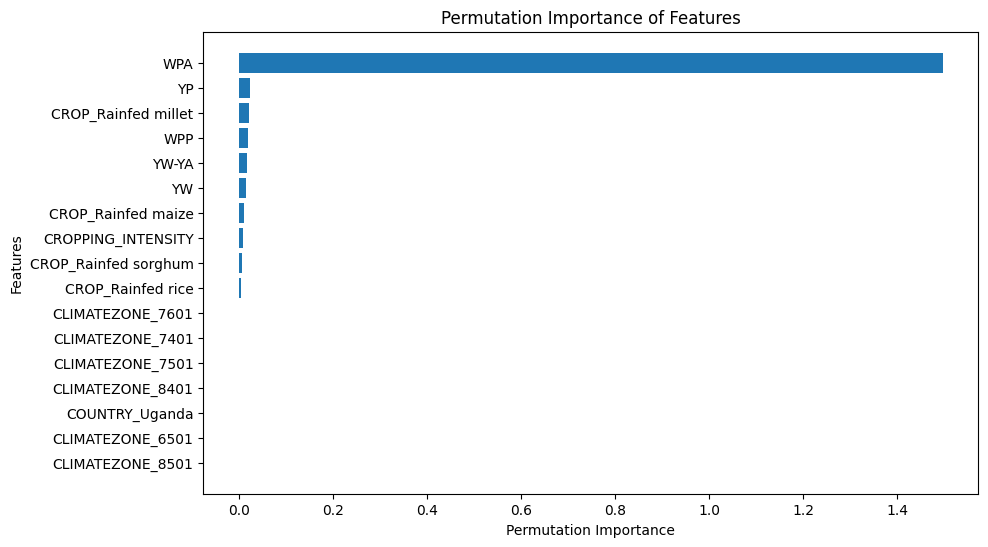

In [31]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_model, X_transformed, y, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Importance of Features")
plt.show()


 ## LIME for Numeric Data

In [37]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['Yield'], mode='regression')

# Explain a single prediction
idx = 5  # Select a test sample
exp = explainer.explain_instance(X_test[idx], rf_model.predict)
exp.show_in_notebook()



In [ ]:
%pip install shap scikit-learn


In [35]:
import shap
import sklearn

print(f"SHAP version: {shap.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

SHAP version: 0.44.1
scikit-learn version: 1.2.2


In [36]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming X_transformed is your preprocessed data (DataFrame) and rf_model is your trained model

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_transformed)

# Visualize SHAP values
# Summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=X_transformed.columns)
plt.show()

# Force plot for the first instance
example_index = 0
shap.force_plot(explainer.expected_value, shap_values[example_index], X_transformed.iloc[example_index], feature_names=X_transformed.columns)

# Dependence plot for the first feature
feature_index = 0
shap.dependence_plot(feature_index, shap_values, X_transformed, feature_names=X_transformed.columns)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'